In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor # Para comparación Nivel Medio
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer # Ya no debería ser necesaria, pero por si acaso
import optuna
import joblib

# Estilo visual
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

# Cargar el dataset limpio (asegúrate que la ruta es correcta)
try:
    df_clean = pd.read_csv('C:/Users/admin/Desktop/MACHINE LEARNING/PLATZI_PROYECTOS/Proyecto_5/train_es_clean.csv')
    print("Dataset limpio cargado exitosamente.")
    print(f"Dimensiones: {df_clean.shape}")
except FileNotFoundError:
    print("Error: El archivo 'train_es_clean.csv' no se encontró. Verifica la ruta.")
    # Detener ejecución si no se carga el archivo
    exit()

# Verificar si realmente no hay NaNs (como resultado del EDA previo)
print("\nVerificación de valores faltantes restantes:")
missing_final = df_clean.isnull().sum().sum()
if missing_final == 0:
    print("No hay valores faltantes. ¡Genial!")
else:
    print(f"ADVERTENCIA: Todavía hay {missing_final} valores faltantes. Revisar el EDA/Limpieza.")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])
    # Considera una imputación adicional simple si es necesario
    # df_clean.fillna(df_clean.median(numeric_only=True), inplace=True) # Ejemplo muy básico

# Revisar tipos de datos de nuevo
print("\nTipos de datos actuales:")
print(df_clean.dtypes.value_counts())

Dataset limpio cargado exitosamente.
Dimensiones: (1460, 81)

Verificación de valores faltantes restantes:
No hay valores faltantes. ¡Genial!

Tipos de datos actuales:
object     43
int64      22
float64    16
Name: count, dtype: int64


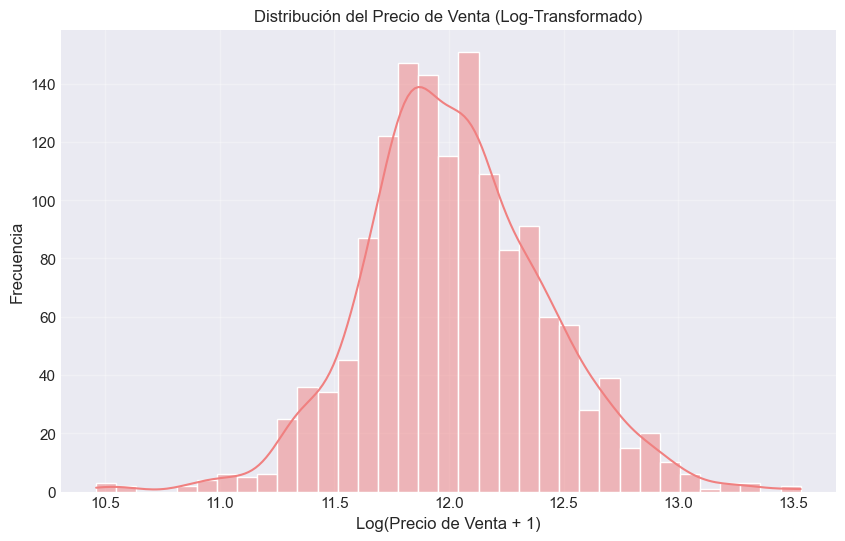

Nuevo Skewness: 0.1213


In [3]:
# Aplicar logaritmo natural + 1 (para manejar posibles ceros, aunque precios no suelen ser 0)
df_clean['PrecioVenta_log'] = np.log1p(df_clean['PrecioVenta'])

# Visualizar la nueva distribución (opcional pero recomendado)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['PrecioVenta_log'], kde=True, color='lightcoral')
plt.title('Distribución del Precio de Venta (Log-Transformado)')
plt.xlabel('Log(Precio de Venta + 1)')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Nuevo Skewness: {df_clean['PrecioVenta_log'].skew():.4f}")

In [4]:
# Separamos características (X) y la variable objetivo transformada (y)
X = df_clean.drop(['Id', 'PrecioVenta', 'PrecioVenta_log'], axis=1)
y = df_clean['PrecioVenta_log'] # Usamos la versión log-transformada

print("Características (X) shape:", X.shape)
print("Objetivo (y) shape:", y.shape)

Características (X) shape: (1460, 79)
Objetivo (y) shape: (1460,)


In [5]:
# Identificar columnas numéricas y categóricas en X
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nCaracterísticas numéricas ({len(numeric_features)}): {numeric_features[:5]}...") # Mostrar solo las primeras 5
print(f"Características categóricas ({len(categorical_features)}): {categorical_features[:5]}...") # Mostrar solo las primeras 5

# Validar si hay alguna columna inesperada
expected_cols = len(numeric_features) + len(categorical_features)
if expected_cols != X.shape[1]:
    print(f"ADVERTENCIA: El número de columnas identificadas ({expected_cols}) no coincide con el total en X ({X.shape[1]}).")
    # Identificar columnas no clasificadas (si las hubiera)
    non_classified_cols = X.columns.difference(numeric_features).difference(categorical_features).tolist()
    print(f"Columnas no clasificadas: {non_classified_cols}")

# Corrección rápida si bool u otros tipos numéricos no fueron capturados
# Por ejemplo, si hay booleanos (Y/N como True/False):
# bool_features = X.select_dtypes(include=['bool']).columns.tolist()
# numeric_features.extend(bool_features) # Tratarlos como numéricos 0/1


Características numéricas (36): ['TipoDeClaseMS', 'FrenteLote', 'ÁreaLote', 'CalidadGeneral', 'CondiciónGeneral']...
Características categóricas (43): ['ZonificaciónMS', 'Calle', 'Callejón', 'FormaLote', 'ContornoTerreno']...


In [6]:
# Crear el preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # Escalar numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # Codificar categóricas
    ],
    remainder='passthrough' # Por si alguna columna no fue clasificada, aunque no debería pasar
)

# Crear el pipeline completo
bayesian_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', BayesianRidge())
])

print("\nPipeline creado exitosamente.")


Pipeline creado exitosamente.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nDatos divididos en entrenamiento y prueba:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Datos divididos en entrenamiento y prueba:
X_train shape: (1168, 79)
X_test shape: (292, 79)
y_train shape: (1168,)
y_test shape: (292,)


In [8]:
print("\nEntrenando el pipeline de Regresión Bayesiana...")
bayesian_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")


Entrenando el pipeline de Regresión Bayesiana...
Entrenamiento completado.


In [9]:
# --- DEFINICIÓN DE LA FUNCIÓN DE EVALUACIÓN ---
# Coloca esta definición ANTES del bloque de código donde la llamas

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np # Asegúrate que numpy está importado

def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Calcula y muestra las métricas RMSE, MAE y R² para un modelo.

    Args:
        y_true: Valores verdaderos de la variable objetivo.
        y_pred: Valores predichos por el modelo.
        model_name (str): Nombre del modelo para mostrar en los prints.

    Returns:
        tuple: Una tupla conteniendo (rmse, mae, r2).
    """
    # Asegurarse de que los inputs son arrays numpy para evitar problemas
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Mostrar resultados
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

    return rmse, mae, r2

# --- TU CÓDIGO EXISTENTE DESDE AQUÍ ---

# ... (código previo: carga de datos, preprocesamiento, entrenamiento, predicción, expm1) ...

# Predicciones en escala logarítmica
y_train_pred_log = bayesian_pipeline.predict(X_train)
y_test_pred_log = bayesian_pipeline.predict(X_test)

# *** Importante: Convertir predicciones y target originales a la escala normal para interpretar MAE/RMSE ***
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)
y_train_pred_orig = np.expm1(y_train_pred_log)
y_test_pred_orig = np.expm1(y_test_pred_log)


print("\n--- Evaluación del Modelo Bayesiano (Escala Original) ---")

print("Rendimiento en Entrenamiento:")
# AHORA ESTA LLAMADA FUNCIONARÁ
rmse_train, mae_train, r2_train = evaluate_model(y_train_orig, y_train_pred_orig, "Bayesian Ridge (Train)")

print("\nRendimiento en Prueba:")
# Y ESTA TAMBIÉN
rmse_test, mae_test, r2_test = evaluate_model(y_test_orig, y_test_pred_orig, "Bayesian Ridge (Test)")

# Chequeo de Overfitting (< 5%)
print("\n--- Chequeo de Overfitting ---")
# Asegurarse que rmse_test no sea cero para evitar división por cero
if rmse_test != 0:
    overfitting_rmse_perc = ((rmse_train - rmse_test) / rmse_test) * 100
    print(f"Diferencia RMSE (Train vs Test): {rmse_train - rmse_test:.2f} ({overfitting_rmse_perc:.2f}%)")
    if abs(overfitting_rmse_perc) < 5:
        print("🟢 Overfitting por debajo del 5%. ¡Cumple el requisito!")
    else:
        print("🟡 Overfitting superior al 5%. Considerar más regularización o revisar características.")
else:
    print("🟡 No se puede calcular el porcentaje de overfitting porque el RMSE de prueba es cero.")



--- Evaluación del Modelo Bayesiano (Escala Original) ---
Rendimiento en Entrenamiento:
  RMSE: 24441.2022
  MAE:  13867.8722
  R²:   0.8998

Rendimiento en Prueba:
  RMSE: 25352.2759
  MAE:  16595.6566
  R²:   0.9162

--- Chequeo de Overfitting ---
Diferencia RMSE (Train vs Test): -911.07 (-3.59%)
🟢 Overfitting por debajo del 5%. ¡Cumple el requisito!


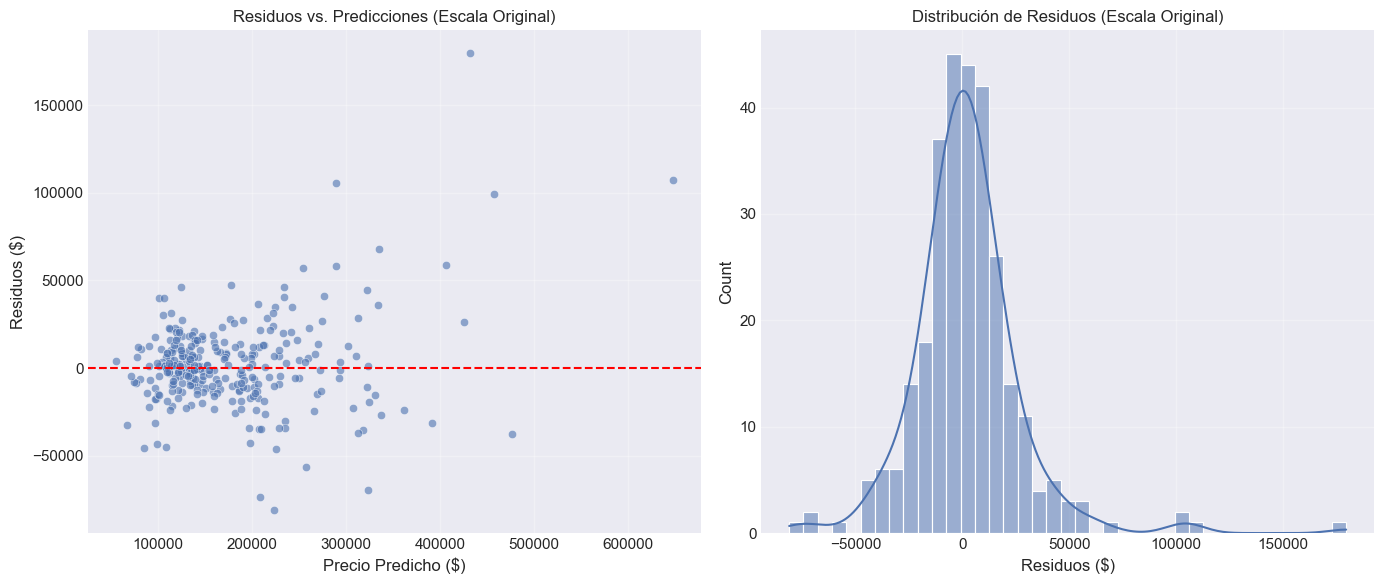

In [10]:
# Calcular residuos en la escala original para mejor interpretación
residuals = y_test_orig - y_test_pred_orig

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_pred_orig, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos vs. Predicciones (Escala Original)')
plt.xlabel('Precio Predicho ($)')
plt.ylabel('Residuos ($)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribución de Residuos (Escala Original)')
plt.xlabel('Residuos ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


--- Importancia de Características (Coeficientes Bayesian Ridge) ---
Top 15 Más Positivas:


Vecindario_Crawfor       0.079638
Vecindario_StoneBr       0.079585
CalidadGeneral           0.075344
Exterior1_BrkFace        0.067931
Vecindario_NridgHt       0.060902
Funcionalidad_Typ        0.060344
MetrosHabitables         0.057724
CalidadSótano_Ex         0.046961
Condición1_Norm          0.042415
CochesGaraje             0.041823
CondiciónGeneral         0.040322
ExposiciónSótano_Gd      0.040186
TipoEdificio_2fmCon      0.040185
CondiciónVenta_Alloca    0.040019
CalidadCocina_Ex         0.038742
dtype: float64


Top 15 Más Negativas:


ZonificaciónMS_RM        -0.029804
TipoVenta_COD            -0.031642
Vecindario_Gilbert       -0.036990
Calefacción_Grav         -0.038889
FormaLote_IR3            -0.040269
CondiciónVenta_Abnorml   -0.040616
ZonificaciónMS_C (all)   -0.044035
TipoEdificio_Twnhs       -0.044881
Funcionalidad_Maj2       -0.048976
Vecindario_MeadowV       -0.050658
ContornoTerreno_Bnk      -0.053723
CalidadPiscina_Gd        -0.055370
Vecindario_Edwards       -0.058498
Condición2_PosN          -0.061916
MaterialTecho_ClyTile    -0.079067
dtype: float64

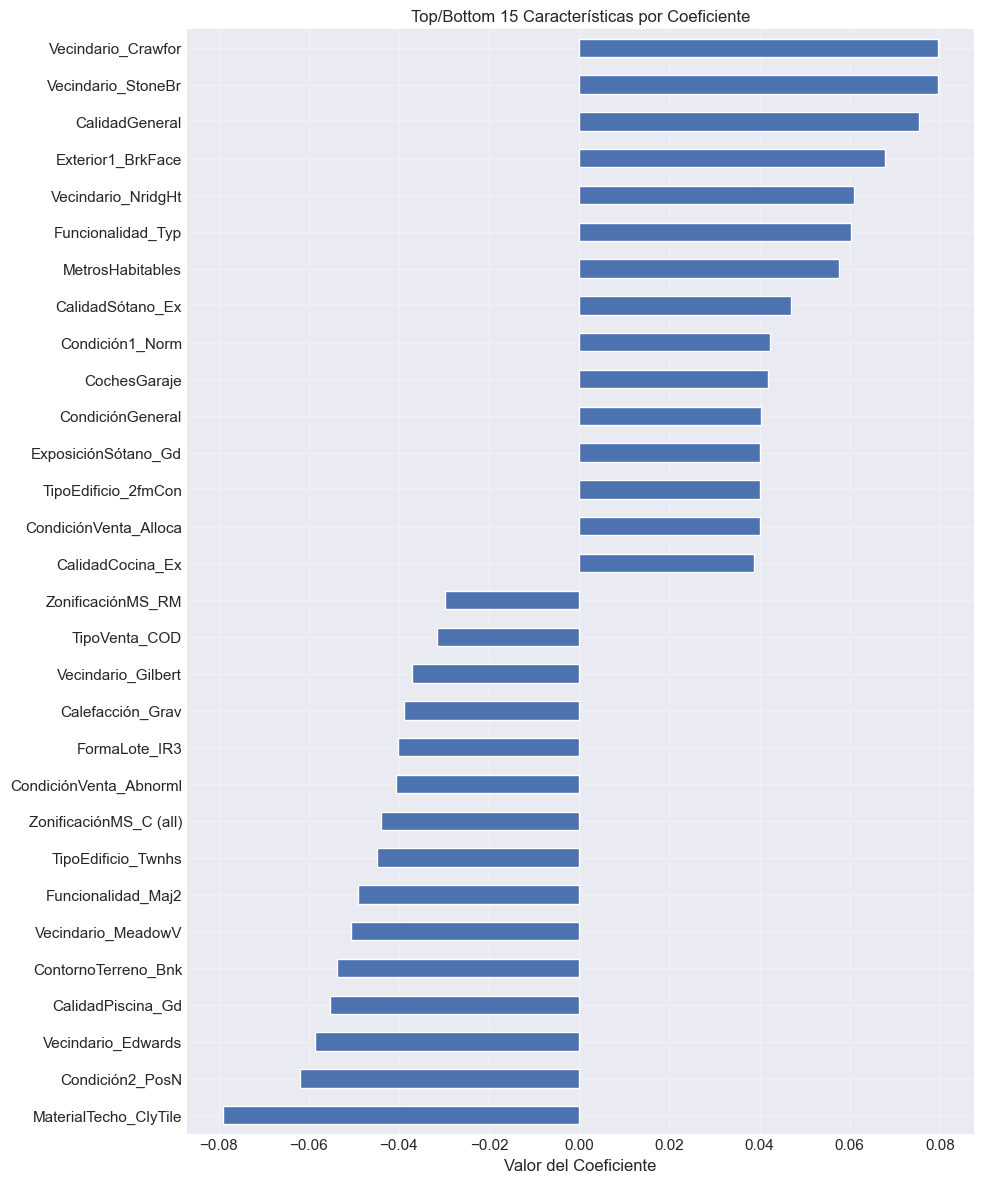

In [11]:
# Obtener los nombres de las características después del preprocesamiento
# Acceder al ColumnTransformer ('preprocessor') y luego al OneHotEncoder ('cat')
onehot_cols = bayesian_pipeline.named_steps['preprocessor'] \
                 .named_transformers_['cat'] \
                 .get_feature_names_out(categorical_features)

# Combinar nombres numéricos y one-hot
# El orden debe coincidir con cómo ColumnTransformer los procesa
transformed_feature_names = numeric_features + list(onehot_cols)

# Obtener los coeficientes del modelo BayesianRidge dentro del pipeline
coefs = bayesian_pipeline.named_steps['regressor'].coef_

# Crear el Series de coeficientes
# Asegurarse que las longitudes coincidan
if len(coefs) == len(transformed_feature_names):
    feature_importance = pd.Series(coefs, index=transformed_feature_names).sort_values(ascending=False)

    print("\n--- Importancia de Características (Coeficientes Bayesian Ridge) ---")
    print("Top 15 Más Positivas:")
    display(feature_importance.head(15))

    print("\nTop 15 Más Negativas:")
    display(feature_importance.tail(15))

    # Graficar las más importantes
    top_bottom_features = pd.concat([feature_importance.head(15), feature_importance.tail(15)]).sort_values()
    plt.figure(figsize=(10, 12))
    top_bottom_features.plot(kind='barh')
    plt.title('Top/Bottom 15 Características por Coeficiente')
    plt.xlabel('Valor del Coeficiente')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("ADVERTENCIA: No se pudo mapear coeficientes a nombres de características debido a diferencia de longitud.")
    print(f"Longitud coeficientes: {len(coefs)}, Longitud nombres: {len(transformed_feature_names)}")

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el pipeline completo con CV
# Usamos neg_mean_squared_error porque RMSE no es directo, luego tomamos raíz cuadrada y quitamos el negativo
cv_scores_mse = cross_val_score(bayesian_pipeline,
                                X_train, # Usar el set de entrenamiento para CV
                                y_train, # Target logarítmico
                                cv=kf,
                                scoring='neg_mean_squared_error', # Evalúa en escala logarítmica
                                n_jobs=-1)

cv_scores_rmse = np.sqrt(-cv_scores_mse) # Convertir a RMSE

print("\n--- Validación Cruzada (K-Fold) para Regresión Bayesiana ---")
print(f"Scores RMSE en cada fold: {cv_scores_rmse}")
print(f"RMSE Medio (CV): {cv_scores_rmse.mean():.4f}")
print(f"Desviación Estándar RMSE (CV): {cv_scores_rmse.std():.4f}")


--- Validación Cruzada (K-Fold) para Regresión Bayesiana ---
Scores RMSE en cada fold: [0.13616859 0.13861335 0.19832917 0.11784369 0.1183067 ]
RMSE Medio (CV): 0.1419
Desviación Estándar RMSE (CV): 0.0295


In [14]:
def objective(trial):
    # Hiperparámetros para BayesianRidge
    alpha_1 = trial.suggest_float('alpha_1', 1e-7, 1e-1, log=True)
    alpha_2 = trial.suggest_float('alpha_2', 1e-7, 1e-1, log=True)
    lambda_1 = trial.suggest_float('lambda_1', 1e-7, 1e-1, log=True)
    lambda_2 = trial.suggest_float('lambda_2', 1e-7, 1e-1, log=True)
    # Otros parámetros como n_iter pueden ser ajustados, pero estos son clave para la regularización
    # n_iter = trial.suggest_int('n_iter', 100, 1000) # Descomentar si quieres probarlo

    # Crear el modelo con los hiperparámetros sugeridos
    model = BayesianRidge(
        alpha_1=alpha_1, alpha_2=alpha_2,
        lambda_1=lambda_1, lambda_2=lambda_2,
        # n_iter=n_iter # Añadir si lo descomentaste arriba
        compute_score=True, # Puede ser útil para ver la convergencia, pero no esencial para Optuna
        fit_intercept=True, # Generalmente True para regresión
        copy_X=True
    )

    # Pipeline solo con preprocesador y el modelo de este trial
    current_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(current_pipeline, X_train, y_train,
                             cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1) # Evaluamos RMSE directamente

    # Optuna busca maximizar, así que devolvemos RMSE promedio (negativo porque es error)
    # OJO: -scores.mean() porque neg_root_mean_squared_error ya es negativo
    return np.mean(-scores) # Queremos minimizar el RMSE promedio positivo

print("\n--- Iniciando Optimización con Optuna ---")
study = optuna.create_study(direction='minimize') # Queremos minimizar el RMSE promedio
# Aumentar n_trials para una búsqueda más exhaustiva si el tiempo lo permite
study.optimize(objective, n_trials=50, timeout=600) # n_trials=50 o 100, timeout opcional (segundos)

print("\nOptimización completada.")
print("Mejor Trial:")
best_trial = study.best_trial
print(f"  Valor (RMSE Medio CV): {best_trial.value:.4f}")
print("  Mejores Hiperparámetros: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Entrenar el modelo final con los mejores hiperparámetros
print("\nEntrenando modelo final Bayesiano Optimizado...")
best_params = best_trial.params
optimised_bayesian_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', BayesianRidge(**best_params))
])

optimised_bayesian_pipeline.fit(X_train, y_train)
print("Entrenamiento final completado.")

# Re-evaluar en el test set
y_test_pred_log_opt = optimised_bayesian_pipeline.predict(X_test)
y_test_pred_orig_opt = np.expm1(y_test_pred_log_opt) # Convertir a escala original

print("\n--- Evaluación del Modelo Bayesiano Optimizado (Escala Original) ---")
evaluate_model(y_test_orig, y_test_pred_orig_opt, "Optimized Bayesian Ridge (Test)")

[I 2025-04-22 11:55:13,335] A new study created in memory with name: no-name-a2b774b6-c919-454a-b63d-90364c48a0e3
[I 2025-04-22 11:55:13,501] Trial 0 finished with value: 0.1418602808660972 and parameters: {'alpha_1': 2.4445247975092514e-07, 'alpha_2': 2.0384276245532193e-05, 'lambda_1': 0.008651531679022242, 'lambda_2': 0.00020103248756423087}. Best is trial 0 with value: 0.1418602808660972.



--- Iniciando Optimización con Optuna ---


[I 2025-04-22 11:55:13,635] Trial 1 finished with value: 0.14380918177454072 and parameters: {'alpha_1': 0.03079264105401059, 'alpha_2': 2.3890083938878326e-05, 'lambda_1': 0.003644819250155641, 'lambda_2': 0.06209513825409099}. Best is trial 0 with value: 0.1418602808660972.
[I 2025-04-22 11:55:13,839] Trial 2 finished with value: 0.1418883218851545 and parameters: {'alpha_1': 0.00011624510078781528, 'alpha_2': 1.3915927732380009e-06, 'lambda_1': 0.0014040989205292118, 'lambda_2': 0.000857695316979786}. Best is trial 0 with value: 0.1418602808660972.
[I 2025-04-22 11:55:13,977] Trial 3 finished with value: 0.14199152231655163 and parameters: {'alpha_1': 0.0006656778922367825, 'alpha_2': 2.4293168369733314e-07, 'lambda_1': 0.0015024032381818896, 'lambda_2': 0.0033231878577414634}. Best is trial 0 with value: 0.1418602808660972.
[I 2025-04-22 11:55:14,100] Trial 4 finished with value: 0.1418486329748388 and parameters: {'alpha_1': 0.01793202695073926, 'alpha_2': 1.1041850313010356e-05, 


Optimización completada.
Mejor Trial:
  Valor (RMSE Medio CV): 0.1418
  Mejores Hiperparámetros: 
    alpha_1: 0.00011562471296022417
    alpha_2: 0.09772446502206593
    lambda_1: 6.139057064825953e-07
    lambda_2: 2.560794253793977e-07

Entrenando modelo final Bayesiano Optimizado...
Entrenamiento final completado.

--- Evaluación del Modelo Bayesiano Optimizado (Escala Original) ---
  RMSE: 25367.4765
  MAE:  16603.5578
  R²:   0.9161


(np.float64(25367.476488905628), 16603.557811732186, 0.916104107435195)

In [15]:
print("\n--- Comparación con RandomForest ---")

# Crear pipeline para RandomForest (reusa el mismo preprocesador)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)) # oob_score es útil
])

print("Entrenando RandomForest...")
rf_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

# Predecir y evaluar RandomForest
y_test_pred_log_rf = rf_pipeline.predict(X_test)
y_test_pred_orig_rf = np.expm1(y_test_pred_log_rf) # Convertir a escala original

print("\nEvaluación de RandomForest (Escala Original):")
evaluate_model(y_test_orig, y_test_pred_orig_rf, "Random Forest (Test)")

# Comparar con Bayesiano Optimizado
print("\nComparativa Final (Test Set - Escala Original):")
print("Optimized Bayesian Ridge:")
evaluate_model(y_test_orig, y_test_pred_orig_opt)
print("\nRandom Forest:")
evaluate_model(y_test_orig, y_test_pred_orig_rf)


--- Comparación con RandomForest ---
Entrenando RandomForest...
Entrenamiento completado.

Evaluación de RandomForest (Escala Original):
  RMSE: 29465.1064
  MAE:  17604.7669
  R²:   0.8868

Comparativa Final (Test Set - Escala Original):
Optimized Bayesian Ridge:
  RMSE: 25367.4765
  MAE:  16603.5578
  R²:   0.9161

Random Forest:
  RMSE: 29465.1064
  MAE:  17604.7669
  R²:   0.8868


(np.float64(29465.106413674217), 17604.766853529327, 0.8868115289339786)

In [16]:
# Guardar el pipeline optimizado que incluye preprocesamiento y modelo
model_filename = 'optimised_bayesian_pipeline.pkl'
joblib.dump(optimised_bayesian_pipeline, model_filename)
print(f"\nPipeline optimizado guardado como '{model_filename}'")


Pipeline optimizado guardado como 'optimised_bayesian_pipeline.pkl'
